# Sentiment Classifier using a Convolutional Neural Network

> Classification of IMDB Reviews 

In [39]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten, Dropout, Embedding, Conv1D, GlobalMaxPool1D, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
import os
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Hyper Parameter choices

In [3]:
out_dir = 'model_out/Conv1d/'
epochs = 5
batch_size = 128 
n_dim = 64
n_unique = 5000
n_skip = 50
max_review = 500
pad_type = trunc_type = 'pre'

## Loading the Data

In [4]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique)

In [5]:
x_train = np.asarray(x_train)
y_train = np.asanyarray(y_train)

In [6]:
print(x_train.shape,y_train.shape)

(25000,) (25000,)


## Preprocessing

In [7]:
x_train = pad_sequences(x_train,maxlen=max_review,padding=pad_type,truncating=trunc_type, value=0)

In [8]:
x_valid = pad_sequences(x_valid,maxlen=max_review,padding=pad_type,truncating=trunc_type, value=0)

## Convnet Architecture

In [46]:
def modeler(n_dense=256,n_drop=0.2,n_drop_em = 0.2,n_conv = 256,k_conv = 3):
    model = Sequential()
    model.add(Embedding(n_unique,n_dim,input_length=max_review))
    model.add(SpatialDropout1D(n_drop_em))
    
    model.add(Conv1D(n_conv,k_conv,padding='same',activation='relu'))
    #model.add(GlobalMaxPool1D())
    
    model.add(Conv1D(n_conv,k_conv,padding='valid',activation='relu'))
    model.add(GlobalMaxPool1D())
    
    model.add(Dense(n_dense,activation='relu'))
    model.add(Dropout(n_drop))
    model.add(Dense(1,activation='sigmoid'))
    model.summary()
    return model

In [47]:
model = modeler()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 64)           320000    
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 500, 64)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 500, 256)          49408     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 498, 256)          196864    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)              

In [48]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
modelcheckpoint = ModelCheckpoint(filepath=out_dir+"weights.{epoch:02d}.hdf5")
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

## Model Training

In [49]:
model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_valid,y_valid),callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 24s 978us/sample - loss: 0.4939 - accuracy: 0.7313 - val_loss: 0.3679 - val_accuracy: 0.8346
Epoch 2/5
25000/25000 [==============================] - 24s 952us/sample - loss: 0.2602 - accuracy: 0.8950 - val_loss: 0.2690 - val_accuracy: 0.8875
Epoch 3/5
25000/25000 [==============================] - 24s 955us/sample - loss: 0.1836 - accuracy: 0.9294 - val_loss: 0.2770 - val_accuracy: 0.8865
Epoch 4/5
25000/25000 [==============================] - 24s 954us/sample - loss: 0.1275 - accuracy: 0.9536 - val_loss: 0.2952 - val_accuracy: 0.8888
Epoch 5/5
25000/25000 [==============================] - 24s 950us/sample - loss: 0.0832 - accuracy: 0.9708 - val_loss: 0.3435 - val_accuracy: 0.8841


## Tensorboard Support

In [13]:
from tensorflow.keras.callbacks import TensorBoard
from time import time

In [14]:
tensorboard = TensorBoard(log_dir=out_dir+"/tdb/"+"logs/{}".format(time()))

In [15]:
model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_valid,y_valid),callbacks=[tensorboard])

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 10s 407us/sample - loss: 0.0412 - accuracy: 0.9876 - val_loss: 0.3627 - val_accuracy: 0.8906
Epoch 2/5
25000/25000 [==============================] - 10s 408us/sample - loss: 0.0233 - accuracy: 0.9936 - val_loss: 0.4247 - val_accuracy: 0.8870
Epoch 3/5
25000/25000 [==============================] - 10s 407us/sample - loss: 0.0164 - accuracy: 0.9952 - val_loss: 0.4525 - val_accuracy: 0.8891
Epoch 4/5
25000/25000 [==============================] - 10s 414us/sample - loss: 0.0144 - accuracy: 0.9961 - val_loss: 0.4827 - val_accuracy: 0.8882
Epoch 5/5
25000/25000 [==============================] - 10s 402us/sample - loss: 0.0141 - accuracy: 0.9955 - val_loss: 0.5107 - val_accuracy: 0.8878


In [17]:
! tensorboard --logdir=model_out/Conv1d/tdb/logs/

TensorBoard 1.14.0a20190301 at http://vinayak-Lenovo-Y520-15IKBN:6006 (Press CTRL+C to quit)
^C


## Loading Model Weights

In [21]:
model.load_weights(out_dir+'weights.02.hdf5')

In [50]:
y_hat = model.predict_proba(x_valid,verbose=1)

25000/25000 [==============================] - 6s 236us/sample


In [51]:
y_hat[0]

array([0.00460148], dtype=float32)

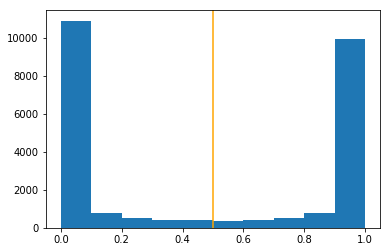

In [52]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5,color = 'orange')

In [53]:
pct = roc_auc_score(y_valid,y_hat)*100.0

In [54]:
"{:0.2f}".format(pct)

'95.39'

In [27]:
def dfr(y_hat):
    y =[]
    for i in y_hat:
        y.append(i[0])
    return y

In [28]:
y_df = dfr(y_hat)

In [29]:
ydf = pd.DataFrame(list(zip(y_df,y_valid)),columns=['y_pred','y_valid'])

In [30]:
ydf.head(10)

,y_pred,y_valid
0,0.024142,0
1,0.990554,1
2,0.772875,1
3,0.282591,0
4,0.910313,1
5,0.448301,1
6,0.876415,1
7,0.003461,0
8,0.981746,0
9,0.910487,1
